In [31]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 

# use tensorflow.keras to build my deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop,Nadam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

# 1. XGBoost Classification Model
## Data Loading
* The XGBoost model doesn't need to reshape the data, and it hasn't need to check the performance on valid set to avoid over-fitting, so we directly split the data into train and test sets.

In [30]:
data = DataPre('/kaggle/input/datatemp/data.csv',4)
data.get_orignal_data()
split_data = data.get_data()

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(split_data.drop(['y'],axis=1), split_data['y'], test_size=test_size, random_state=seed)

## Model Training and Testing
* In this cell, we build a XGBClassifier and train it by using the built-in function fit.
* Here will also show the model's performance, which can be directly compared with LSTM model.

In [32]:
xg_model = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=50, silent=True, objective="binary:logistic", booster='gbtree') #初始化模型
xg_model.fit(X_train, y_train)
y_pred = xg_model.predict(X_test)

model_score(y_test,y_pred)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:14:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


classify_report : 
               precision    recall  f1-score   support

         0.0       0.58      0.92      0.71     55406
         1.0       0.62      0.16      0.25     43655

    accuracy                           0.59     99061
   macro avg       0.60      0.54      0.48     99061
weighted avg       0.60      0.59      0.51     99061

confusion_matrix : 
 [[51237  4169]
 [36807  6848]]
acc_for_each_class : 
 [0.58194766 0.62158482]
average_accuracy: 0.601766
overall_accuracy: 0.586356
score: 0.586356


# 2. LSTM Classification Model
## Model Evaluation
* This function will show the performance of the model prediction, the performance includes confusion matrix, accuracy and classify report.

In [24]:
def model_score(y_true, y_pred):
    classify_report = metrics.classification_report(y_true, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    overall_accuracy = metrics.accuracy_score(y_true, y_pred)
    acc_for_each_class = metrics.precision_score(y_true, y_pred, average=None)
    average_accuracy = np.mean(acc_for_each_class)
    score = metrics.accuracy_score(y_true, y_pred)
    print('classify_report : \n', classify_report)
    print('confusion_matrix : \n', confusion_matrix)
    print('acc_for_each_class : \n', acc_for_each_class)
    print('average_accuracy: {0:f}'.format(average_accuracy))
    print('overall_accuracy: {0:f}'.format(overall_accuracy))
    print('score: {0:f}'.format(score))

## Data Processing and Loading
* The class DataPre reads data from data file (the preprocessed data) and members the base information of data.
* The n-gram parameter is a temporal feature, we will aggreate the n-gram time-points data into one record, which will contai the temporal information. 

In [25]:
class DataPre():
    def __init__(self,filename,n_gram):
        self.filename = filename
        self.n_gram = n_gram

    def get_orignal_data(self):
        self.orignal_data = pd.read_csv(self.filename,header=None)
        self.orignal_data = self.orignal_data.groupby([11]).apply(lambda x :x[1:-1])
        self.orignal_data.dropna(inplace=True)
        self.orignal_data.drop([11],axis=1,inplace=True)
        self.orignal_data = self.orignal_data.reset_index()

    def data_split(self,x):
        orignal_data_x = x[[i for i in range(10)]]
        orignal_data_y = x[10]
        data_ = np.concatenate(orignal_data_x.values)
        split_data = pd.DataFrame([ data_[i*10:i*10+10*self.n_gram ] for i in range(len(orignal_data_x)-self.n_gram+1 )])
        split_data_y = orignal_data_y[self.n_gram-1:].values
        split_data['y'] = split_data_y
        return split_data
    
    def get_data(self):
        result = self.orignal_data.drop(['level_1'],axis=1).groupby([11]).apply(lambda x:self.data_split(x))
        result = pd.DataFrame(result.values)
        result.rename(columns={result.columns[-1]:'y'},inplace=True)
        return result
    

* This cell loads the data for LSTM model, we use the sklearn's built-in function train-test-split to split the train, valid and test sets. These three dataset need to be reshaped to three dimensions for LSTM model. 

In [26]:
seed = 7
test_size = 0.2
data = DataPre('/kaggle/input/datatemp/data.csv',4)
data.get_orignal_data()
split_data = data.get_data()

# split data into train, valid and test sets
X_train, X_test, y_train, y_test = train_test_split(split_data.drop(['y'],axis=1), split_data['y'], test_size=test_size, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train , test_size=0.2, random_state=seed)

# reshape the three datasets
X_train = np.reshape(X_train.values, (X_train.shape[0],  X_train.shape[1], 1))
X_valid = np.reshape(X_valid.values, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

## Model Building
* In this step, we use the keras blocks to build a four-layers LSTM model, the number of hidden units is 50, the last layer is a softmax layer. The model inputs three-dimensional data and outputs two values, which represent the probabilities of fall and raise of stock price.

In [27]:
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 2,activation='softmax'))

# the model's optimizer is Nadam
optimizer = Nadam(lr=0.001, epsilon=None, decay=0.01)
# we use earlystopping strategy to train the model
callback = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, mode="auto")

model.compile(optimizer = optimizer,  loss='categorical_crossentropy', metrics=['accuracy'])


## Model Training
* This cell will show the LSTM model training process.

In [28]:
history = model.fit(X_train, to_categorical(y_train, 2), epochs = 100, batch_size=72, validation_data=(X_valid, to_categorical(y_valid,2)),callbacks=[callback], verbose=1)

# model saving
model.save('lstm-model.h5')

Epoch 1/100
4403/4403 [==============================] - 77s 16ms/step - loss: 0.6788 - accuracy: 0.5732 - val_loss: 0.6560 - val_accuracy: 0.6021
Epoch 2/100
4403/4403 [==============================] - 70s 16ms/step - loss: 0.6603 - accuracy: 0.5963 - val_loss: 0.6495 - val_accuracy: 0.6104
Epoch 3/100
4403/4403 [==============================] - 71s 16ms/step - loss: 0.6549 - accuracy: 0.6022 - val_loss: 0.6472 - val_accuracy: 0.6130
Epoch 4/100
4403/4403 [==============================] - 70s 16ms/step - loss: 0.6515 - accuracy: 0.6075 - val_loss: 0.6517 - val_accuracy: 0.6078
Epoch 5/100
4403/4403 [==============================] - 71s 16ms/step - loss: 0.6490 - accuracy: 0.6120 - val_loss: 0.6403 - val_accuracy: 0.6246
Epoch 6/100
4403/4403 [==============================] - 70s 16ms/step - loss: 0.6487 - accuracy: 0.6118 - val_loss: 0.6421 - val_accuracy: 0.6223
Epoch 7/100
4403/4403 [==============================] - 70s 16ms/step - loss: 0.6460 - accuracy: 0.6159 - val_loss: 0

## Model Prediction
* After obtaining the best trained model, we can use it to predict the test dataset, here will show the performance of LSTM model prediction.

In [29]:
lstm_model = load_model('lstm-model.h5')
y_pred = lstm_model.predict(X_test)
model_score(y_test,y_pred.argmax(axis=1))

classify_report : 
               precision    recall  f1-score   support

         0.0       0.65      0.72      0.68     55406
         1.0       0.59      0.52      0.55     43655

    accuracy                           0.63     99061
   macro avg       0.62      0.62      0.62     99061
weighted avg       0.63      0.63      0.63     99061

confusion_matrix : 
 [[39652 15754]
 [20906 22749]]
acc_for_each_class : 
 [0.65477724 0.59083708]
average_accuracy: 0.622807
overall_accuracy: 0.629925
score: 0.629925


# 3. LSTM Regressor
In this part, we try to use LSTM model to regress the stock price in the future period.
## Data Loading
* The class DataPrePrice is used to read the data file from data2.csv, which contains the stock price at each moment.

In [33]:
class DataPrePrice():
    def __init__(self,filename,n_gram):
        self.filename = filename
        self.n_gram = n_gram

    def get_orignal_data(self):
        self.orignal_data = pd.read_csv(self.filename,header=None)
        self.orignal_data = self.orignal_data.groupby([11]).apply(lambda x :x[1:-1])
        self.orignal_data.dropna(inplace=True)
        self.orignal_data.drop([11],axis=1,inplace=True)
        self.orignal_data = self.orignal_data.reset_index()

    def data_split(self,x):
        orignal_data_x = x[[i for i in range(10)]]
        # this line read the stock price as label, rather than 
        orignal_data_y = x[12]
        data_ = np.concatenate(orignal_data_x.values)
        split_data = pd.DataFrame([ data_[i*10:i*10+10*self.n_gram ] for i in range(len(orignal_data_x)-self.n_gram+1 )])
        split_data_y = orignal_data_y[self.n_gram-1:].values
        split_data['y'] = split_data_y
        return split_data
    
    def get_data(self):
        result = self.orignal_data.drop(['level_1'],axis=1).groupby([11]).apply(lambda x:self.data_split(x))
        result = pd.DataFrame(result.values)
        result.rename(columns={result.columns[-1]:'y'},inplace=True)
        return result


* Load data with stock price, split the data into train, valid and test sets and reshape these dataset to three dimensions.

In [34]:
data = DataPrePrice('/kaggle/input/datatemp/datav2.csv',4)
data.get_orignal_data()
split_data = data.get_data()

X_train, X_test, y_train, y_test = train_test_split(split_data.drop(['y'],axis=1), split_data['y'], test_size=test_size, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train , test_size=0.2, random_state=seed)

X_train = np.reshape(X_train.values, (X_train.shape[0],  X_train.shape[1], 1))
X_valid = np.reshape(X_valid.values, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

## LSTM Regressor Building
* This process is same as the LSTM classifier building, we change the model's output layer, which represent the stock price value. 

In [35]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

# use the RMSprop as the optimizer
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

# use mean squared error as the loss function of this regressor
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


## Regressor Training

In [59]:
regressor.fit(X_train, y_train, epochs = 40, batch_size=256, validation_data=(X_valid, y_valid), verbose=1)
regressor.save('lstm-regressor.h5')

Epoch 1/40
1239/1239 [==============================] - 20s 16ms/step - loss: 112.5163 - val_loss: 8.4728
Epoch 2/40
1239/1239 [==============================] - 19s 15ms/step - loss: 110.7125 - val_loss: 11.0647
Epoch 3/40
1239/1239 [==============================] - 19s 16ms/step - loss: 110.0893 - val_loss: 8.6333
Epoch 4/40
1239/1239 [==============================] - 19s 16ms/step - loss: 109.2513 - val_loss: 9.0585
Epoch 5/40
1239/1239 [==============================] - 19s 16ms/step - loss: 108.4693 - val_loss: 12.4547
Epoch 6/40
1239/1239 [==============================] - 19s 16ms/step - loss: 107.6305 - val_loss: 14.8339
Epoch 7/40
1239/1239 [==============================] - 19s 16ms/step - loss: 107.4735 - val_loss: 10.9897
Epoch 8/40
1239/1239 [==============================] - 19s 16ms/step - loss: 106.0338 - val_loss: 11.4229
Epoch 9/40
1239/1239 [==============================] - 19s 15ms/step - loss: 104.8364 - val_loss: 10.9549
Epoch 10/40
1239/1239 [=================

## Regressor Testing

In [60]:
y_predict = regressor.predict(X_test)
mean_squared_error(y_test, y_predict)

8.837373725846325

# 4 Visualization
* In this section, we visualize the above three models' prediction on a period of stock price floating.

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


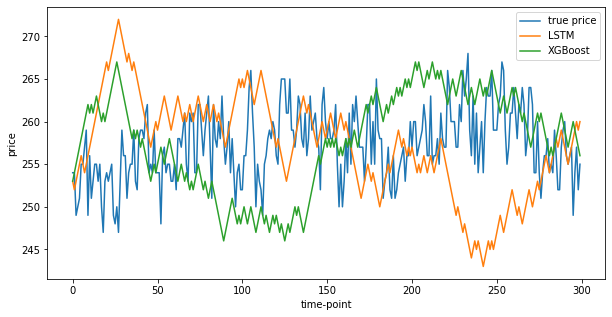

In [53]:
# Testing data
data = DataPrePrice('datav2.csv',4)
data.get_orignal_data()
split_data = data.get_data()

s_idx = 1000
length = 300

pred_data_x = split_data[s_idx:s_idx+length].drop(['y'], axis=1)
pred_data_y = split_data[s_idx:s_idx+length]['y']

xg_pred = xg_model.predict(pred_data_x)

pred_data_x = np.reshape(pred_data_x.values, (pred_data_x.shape[0],  pred_data_x.shape[1], 1))
s = split_data[s_idx-1:s_idx]['y']

y_pred = lstm_model.predict(pred_data_x)

pred_v = [s]
for e in np.argmax(y_pred, axis=1):
    if e == 1:
        pred_v.append(s + 1)
    else:
        pred_v.append(s - 1)
    
    s = pred_v[-1]
    
s = split_data[s_idx-1:s_idx]['y']
pred_v_xg = [s]
for e in xg_pred:
    if e == 1:
        pred_v_xg.append(s + 1)
    else:
        pred_v_xg.append(s - 1)
    
    s = pred_v_xg[-1]
    
plt.figure(figsize=(10, 5))

plt.plot(list(range(length)), pred_data_y, label='true price')
plt.plot(list(range(length)), pred_v[:-1], label='LSTM')
plt.plot(list(range(length)), pred_v_xg[:-1], label='XGBoost')

plt.legend()

plt.xlabel('time-point')
plt.ylabel('price')

plt.savefig('fig1.svg')
plt.show()

Fig. 1 shows the above two classifiers’ prediction results over a period of time (300 time-points) on the test set. We define the amplitude as 1. From the result, both the LSTM model and the XGBoost model have poor ability to predict the fluctuation of stock price. But in some time periods, the trend predicted by the model is similar to the real trend. For example, in the 230-270 time-point interval, the XGBoost classifier fits the real stock price, and in the 70-120 time-point interval, the LSTM classifier prediction is accurate. Overall, these two models can capture a part of the floating patterns of stock price. However, neither of these two models is capable enough to guide investors and may even give wrong information.

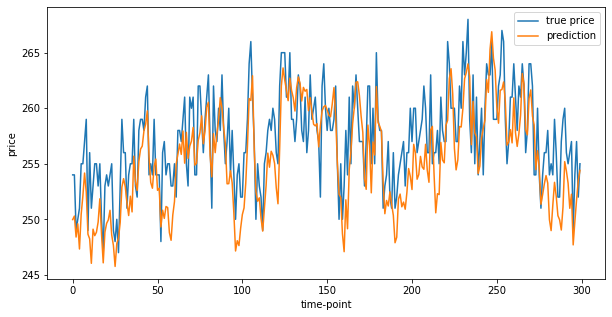

In [61]:
s_idx = 1000
length = 300

x = split_data[s_idx:s_idx+length].drop(['y'], axis=1)
x = np.reshape(x.values, (x.shape[0],  x.shape[1], 1))

y = split_data[s_idx:s_idx+length]['y']

y_p = regressor.predict(x)

plt.figure(figsize=(10, 5))

plt.plot(list(range(length)), y, label='true price')
plt.plot(list(range(length)), y_p, label='prediction')

plt.xlabel('time-point')
plt.ylabel('price')

plt.legend()

plt.savefig('fig2.svg')
plt.show()

Fig. 2 shows the LSTM regressor prediction result over a period of time (300 time-points) on the test set. The curve predicted by the LSTM regressor has a high correlation with the real stock price curve, which shows that the regressor has the ability to predict the stock price. From the overall trend, the model prediction is accurate, but there will be some bias at the specific moment. In practice, the trend prediction of stock prices is of great significance to investors, and the time-point of the rise or fall of stock prices can help investors make decisions in advance.